<a href="https://colab.research.google.com/github/octavioeac/ads-spend/blob/main/AD_Spend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **The analysis aims to clean and validate the ads dataset, calculate acquisition efficiency (CAC) and return efficiency (ROAS), and compare performance over time and across segments (platform, country, device). The goal is to identify patterns and trends that can guide marketing budget allocation and campaign optimization.**


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
url = "https://raw.githubusercontent.com/octavioeac/ads-spend/refs/heads/main/notebooks/data/ads_spend.csv"
df = pd.read_csv(url)
df.head()

,date,platform,account,campaign,country,device,spend,clicks,impressions,conversions
0,2025-01-01,Meta,AcctA,Prospecting,MX,Desktop,1115.94,360,15840,29
1,2025-01-01,Google,AcctA,Brand_Search,CA,Mobile,789.43,566,22640,28
2,2025-01-01,Google,AcctA,Prospecting,BR,Desktop,381.40,133,10241,12
3,2025-01-01,Google,AcctC,Prospecting,US,Desktop,1268.34,891,49005,36
4,2025-01-01,Google,AcctA,Brand_Search,BR,Desktop,1229.70,628,21352,31


In [4]:

# Shape of the dataset
print("Shape:", df.shape)

# 1. Null values
print("\nMissing values per column:")
print(df.isnull().sum())

# 2. Duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())

# 3. Data types (categorical vs numerical)
print("\nData types:")
print(df.dtypes)

# 4. Unique values in categorical columns
categorical_cols = df.select_dtypes(include=["object"]).columns
print("\nUnique values per categorical column:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

Shape: (2000, 10)

Missing values per column:
date           0
platform       0
account        0
campaign       0
country        0
device         0
spend          0
clicks         0
impressions    0
conversions    0
dtype: int64

Number of duplicate rows: 0

Data types:
date            object
platform        object
account         object
campaign        object
country         object
device          object
spend          float64
clicks           int64
impressions      int64
conversions      int64
dtype: object

Unique values per categorical column:
date: 181 unique values
platform: 2 unique values
account: 3 unique values
campaign: 4 unique values
country: 4 unique values
device: 2 unique values


#Create a function to clean the dataset

In [5]:
def clean_dataset(df):
    # 1. Drop duplicates
  df = df.drop_duplicates()
  print("After removing duplicates:", df.shape)

  # 2. Handle missing values
  # Strategy: drop rows if key fields (date, platform, campaign, spend, conversions) are missing
  df = df.dropna(subset=["date", "platform", "campaign", "spend", "conversions"])
  print("After dropping critical nulls:", df.shape)

  # 3. Fill less critical categorical nulls with "unknown"
  for col in ["country", "device", "account"]:
      if col in df.columns:
          df[col] = df[col].fillna("unknown")

  # 4. Ensure numeric columns have valid values
  numeric_cols = ["spend", "clicks", "impressions", "conversions"]
  for col in numeric_cols:
      df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

  # 5. Protect against division by zero
  df = df[(df["conversions"] > 0) & (df["spend"] > 0)]

  # 6. Add KPIs safely
  df["revenue"] = df["conversions"] * 100
  df["cac"] = df["spend"] / df["conversions"]
  df["roas"] = df["revenue"] / df["spend"]

  return df.head()

df_clean = clean_dataset(df)
df_clean.head()


After removing duplicates: (2000, 10)
After dropping critical nulls: (2000, 10)


,date,platform,account,campaign,country,device,spend,clicks,impressions,conversions,revenue,cac,roas
0,2025-01-01,Meta,AcctA,Prospecting,MX,Desktop,1115.94,360,15840,29,2900,38.480690,2.598706
1,2025-01-01,Google,AcctA,Brand_Search,CA,Mobile,789.43,566,22640,28,2800,28.193929,3.546863
2,2025-01-01,Google,AcctA,Prospecting,BR,Desktop,381.40,133,10241,12,1200,31.783333,3.146303
3,2025-01-01,Google,AcctC,Prospecting,US,Desktop,1268.34,891,49005,36,3600,35.231667,2.838356
4,2025-01-01,Google,AcctA,Brand_Search,BR,Desktop,1229.70,628,21352,31,3100,39.667742,2.520940


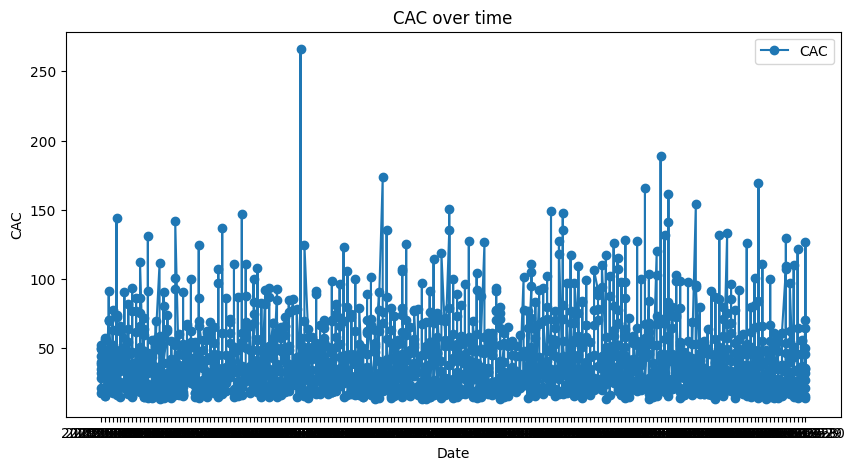

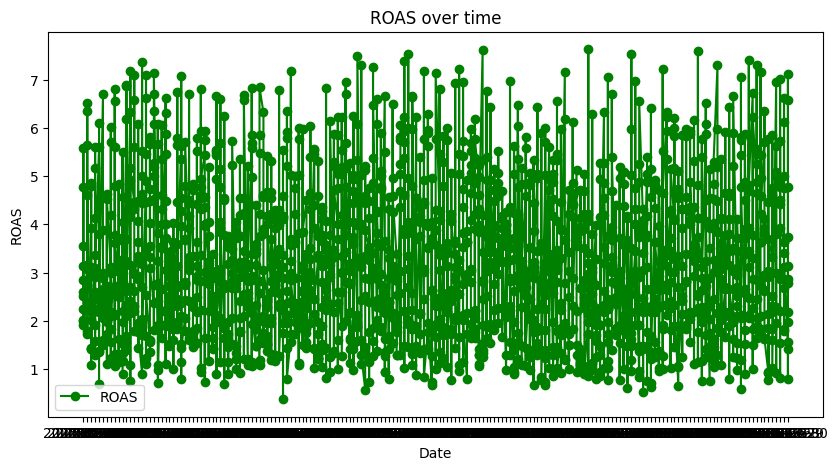

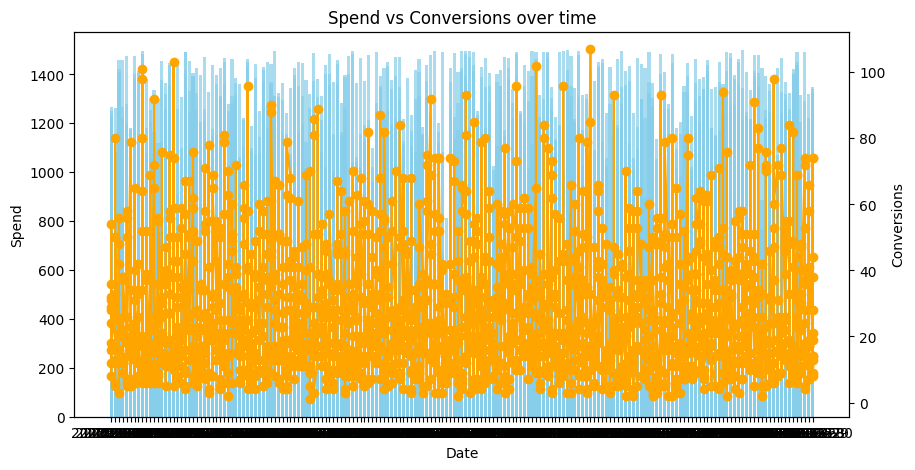

In [8]:
# Preprocess (basic KPIs)
df["revenue"] = df["conversions"] * 100
df["cac"] = df["spend"] / df["conversions"].replace(0, pd.NA)
df["roas"] = df["revenue"] / df["spend"].replace(0, pd.NA)

# 1. CAC trend
plt.figure(figsize=(10,5))
plt.plot(df["date"], df["cac"], marker="o", label="CAC")
plt.title("CAC over time")
plt.xlabel("Date")
plt.ylabel("CAC")
plt.legend()
plt.show()

# 2. ROAS trend
plt.figure(figsize=(10,5))
plt.plot(df["date"], df["roas"], marker="o", color="green", label="ROAS")
plt.title("ROAS over time")
plt.xlabel("Date")
plt.ylabel("ROAS")
plt.legend()
plt.show()

# 3. Spend vs Conversions
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(df["date"], df["spend"], color="skyblue", alpha=0.7, label="Spend")
ax2 = ax1.twinx()
ax2.plot(df["date"], df["conversions"], color="orange", marker="o", label="Conversions")

ax1.set_xlabel("Date")
ax1.set_ylabel("Spend")
ax2.set_ylabel("Conversions")
plt.title("Spend vs Conversions over time")
plt.show()

In [10]:
daily = df.groupby("date", as_index=True).agg({
    "spend":"sum",
    "conversions":"sum"
})
daily["revenue"] = daily["conversions"] * 100
daily["cac"] = daily["spend"] / daily["conversions"].replace(0, pd.NA)
daily["roas"] = daily["revenue"] / daily["spend"].replace(0, pd.NA)
daily.head()

,spend,conversions,revenue,cac,roas
date,,,,,
2025-01-01,9681.55,288,28800,33.616493,2.974730
2025-01-02,7977.48,317,31700,25.165552,3.973686
2025-01-03,10644.56,280,28000,38.016286,2.630452
2025-01-04,9671.21,269,26900,35.952454,2.781451
2025-01-05,8961.84,278,27800,32.236835,3.102042


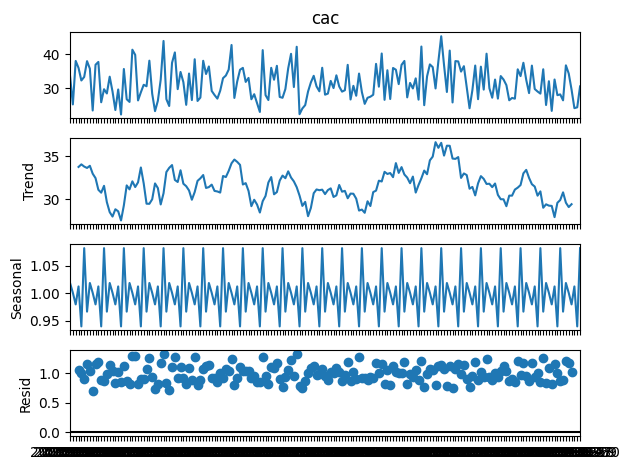

In [14]:
result = seasonal_decompose(daily["cac"].dropna(), model="multiplicative", period=7)
result.plot()
plt.show()

In [16]:
!pip install ruptures
import ruptures as rpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.7 MB/s eta 0:00:00


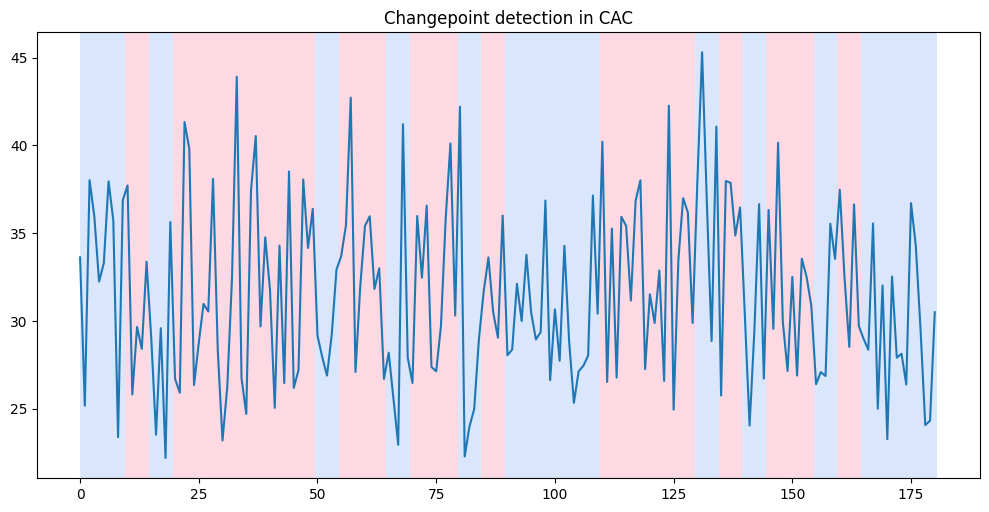

In [17]:
series = daily["cac"].dropna().values

# Modelo de quiebres (PELT con costo L2)
model = rpt.Pelt(model="l2").fit(series)
breaks = model.predict(pen=10)

# Visualizar
rpt.display(series, breaks, figsize=(10,5))
plt.title("Changepoint detection in CAC")
plt.show()

## Justification: Why Fourier for Marketing Performance Analysis

When analyzing marketing performance metrics such as **CAC (Customer Acquisition Cost)** and **ROAS (Return on Ad Spend)**, one of the main challenges is that the data is not static — it changes daily, is affected by campaign launches, and often contains cycles that repeat over time (for example, weekdays versus weekends, or end-of-month spending pushes).

Looking only at raw averages or single-point comparisons (e.g., last 30 days vs. prior 30 days) can be misleading, because we risk confusing **seasonal cycles** with **real performance changes**. For instance, a sudden spike in CAC might not mean the campaigns are deteriorating — it could simply be a weekend effect or a known monthly cycle.

This is where **Fourier analysis** becomes valuable. Fourier transforms allow us to break down a time series into its fundamental **frequencies**, showing whether there are strong recurring patterns (weekly, monthly) or if the series is dominated by long-term trends or random noise.

- **Low frequencies** → reveal **long-term trends**, telling us if efficiency is improving or worsening over time.  
- **Medium frequencies** → highlight **seasonality**, such as weekly cycles of user engagement or ad performance.  
- **High frequencies** → often represent **noise**, helping us distinguish random fluctuations from meaningful signals.  

By applying Fourier analysis to CAC and ROAS, we move from simply *observing noisy curves* to **quantifying the cycles and patterns** that actually drive campaign efficiency. This helps decision makers answer questions like:

- *“Is CAC really increasing, or is this just a weekend effect?”*  
- *“Do we see a consistent monthly cycle where ROAS spikes at the beginning of the month?”*  
- *“Are there structural breaks (changepoints) that indicate something truly changed in campaign strategy or market behavior?”*  

In short, **Fourier analysis humanizes the problem by allowing us to separate what is structural (trend), what is natural and repeating (seasonality), and what is random (noise).** This makes performance insights not only more accurate, but also actionable — guiding smarter decisions on when and where to allocate ad spend.


## Mathematical Justification for Fourier Analysis in Time Series

Let a time series of a marketing metric (e.g., CAC or ROAS) be represented as:

$$
x(t), \quad t = 1,2,\dots,N
$$

where $x(t)$ is the observed value on day $t$.

---

### 1. Fourier Representation
The **Discrete Fourier Transform (DFT)** expresses $x(t)$ as a sum of sinusoidal functions:

$$
X(k) = \sum_{t=0}^{N-1} x(t) \, e^{-i 2\pi kt / N}, \quad k = 0,1,\dots,N-1
$$

- $X(k)$ are the Fourier coefficients (complex numbers).  
- The magnitude $|X(k)|$ indicates the strength of the frequency component $k/N$.  
- The phase $\arg(X(k))$ indicates the shift of that frequency.  

Thus, the original series can be reconstructed as:

$$
x(t) = \frac{1}{N}\sum_{k=0}^{N-1} X(k) \, e^{i 2\pi kt / N}
$$

---

### 2. Link to Trend, Seasonality, and Noise
- **Low frequencies** ($k \approx 0$) → correspond to **long-term trend** in CAC/ROAS.  
- **Medium frequencies** ($k \approx N/7$, $N/30$) → capture **weekly or monthly seasonality**.  
- **High frequencies** → correspond to **random noise** or day-to-day fluctuations.  

By analyzing $|X(k)|$, we can quantify which cycles dominate the series.

---

### 3. Practical Implication
Suppose CAC shows a strong frequency peak at $k = N/7$.  
This means:

$$
x(t) \approx A \cos\left(\frac{2\pi}{7}t + \phi\right)
$$

where $A$ is the amplitude (intensity of the weekly cycle).  

**Interpretation:** CAC systematically varies every 7 days → **weekly advertising pattern**.

---

### 4. Why Fourier is Justified
Fourier analysis provides a rigorous way to:

1. **Decompose** a noisy metric into deterministic components (trend + cycles).  
2. **Identify hidden periodicities** that are not obvious in raw data.  
3. **Distinguish structural behavior** (trend, seasonality) from randomness (noise).  

This makes it ideal for marketing performance data, where campaigns often follow **weekly and monthly cycles**, and distinguishing them from real performance changes is crucial.
